## Schultze data processing.

This is to explore and processe the Schultze #### data.

__author__ = "Ciro Ramírez-Suástegui"


__copyright__ = "Copyright 2022-06-30, Helmholtz Zentrum Muenchen"

__license__ = "GPL"

__version__ = "0.0.9"

__maintainer__ = "Ciro Ramírez-Suástegui"

__email__ = "ciro.suastegui@helmholtz-muenchen.de, ksuasteguic@gmail.com"

__status__ = "Prototype"

#### Structure

* [Load data](#bullet1)
* [Raw counts in adata.X](#bullet2)
* [Metadata harmonization](#bullet3)
* [Quality Control](#bullet4)
* [Remove doublets](#bullet5)
* [Make object lightweight](#bullet6)
* [Check if you need to split them into datasets](#bullet7)
* [Write down everything you did in the "preprocessing" column](#bullet8)
* [Subset to HVGs](#bullet8)
* [Store the data](#bullet10)
* [Update the stats for your dataset](#bullet11)

### Environment setup

In [1]:
# basic modules
import os, re, time, importlib
import sys, warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
from IPython.display import clear_output

In [2]:
# in-house/developing modules
sys.path.append("../../../scripts/")
import preprocessing as pp
# tools modules
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import random
sc.logging.print_versions()

The `sinfo` package has changed name and is now called `session_info` to become more discoverable and self-explanatory. The `sinfo` PyPI package will be kept around to avoid breaking old installs and you can downgrade to 0.3.2 if you want to use it without seeing this message. For the latest features and bug fixes, please install `session_info` instead. The usage and defaults also changed slightly, so please review the latest README at https://gitlab.com/joelostblom/session_info.
-----
anndata     0.7.8
scanpy      1.8.2
sinfo       0.3.4
-----
PIL                         9.0.0
backcall                    0.2.0
beta_ufunc                  NA
binom_ufunc                 NA
cached_property             1.5.2
cffi                        1.15.0
colorama                    0.4.4
cycler                      0.10.0
cython_runtime              NA
dateutil                    2.8.2
debugpy                     1.5.1
decorator                   5.1.1
defusedxml                  0.7.1
entrypoints   

In [3]:
# setting visualisation parameters
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(10, 10))

In [4]:
print("Environment:", re.sub('.os.py', '', os.__file__))
parentpath = lambda _path, n: os.sep.join(_path.split(os.sep)[:-n])
print("Working at:", re.sub(parentpath(os.getcwd(), 2), '', os.getcwd()))

Environment: /home/icb/ciro.suastegui/miniconda3/envs/scarches_0_3_5/lib/python3.7
Working at: /3_atlas_extension/HLCA_extension_data_preprocessing


In [5]:
spam_spec = importlib.util.find_spec("load_ext")
if spam_spec is not None:
    %load_ext autoreload
    %autoreload 2
    %load_ext lab_black
else:
    print("No pretty code for us today")

No pretty code for us today


### Global variables and paths

In [6]:
adata_inp = "../../../../unprocessed_new_datasets/schultze/Kapellos_healthy.h5ad"
adata_dir_out = "../../../data/HLCA_extended/extension_datasets/ready"
mdata_donor_inp = "../../../data/HLCA_extended/extension_datasets/metadata/Schultze_unpubl.xlsx"
feats_inp = "../../../../unprocessed_new_datasets/schultze/ensembl_ids_and_symbols.csv"
genes_set_inp = "../../../notebooks/3_atlas_extension/HLCA_extension_data_preprocessing/genes_for_mapping.csv"

### Load data <a class="anchor" id="bullet1"></a>

In [7]:
adata = sc.read_h5ad(adata_inp)
adata_obs = adata.obs

In [8]:
adata

AnnData object with n_obs × n_vars = 8016 × 24532
    obs: 'cells'
    var: 'genes'
    uns: 'BMI', 'CMV_vaccination', 'FEV1', 'FVC', 'LuT', 'PCT_INTERGENIC_BASES', 'PCT_INTRONIC_BASES', 'age', 'blood_group', 'classification', 'disease_tissue', 'general_final_annotation', 'immediate', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'other_diagnosis', 'percent.mt', 'sex', 'site', 'smoking'

### Raw counts in adata.X <a class="anchor" id="bullet2"></a>

In [9]:
print(adata.layers, len(adata.layers))
print("Is adata.raw present?", adata.raw is not None)

Layers with keys:  0
Is adata.raw present? False


In [10]:
adata.X[:10,:10].A

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [7., 0., 0., 0., 0., 0., 0., 0., 0., 2.],
       [8., 3., 0., 0., 0., 0., 1., 0., 0., 4.],
       [1., 0., 0., 2., 1., 0., 0., 0., 0., 1.],
       [3., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [2., 0., 0., 0., 0., 0., 0., 1., 0., 1.],
       [5., 0., 0., 1., 2., 1., 0., 0., 0., 7.],
       [8., 1., 0., 0., 0., 0., 0., 0., 0., 3.]], dtype=float32)

In [11]:
pd.Series(adata.X[:100,:100].A.flatten()).value_counts().head(10)

0.0    7570
1.0    1255
2.0     482
3.0     236
4.0     135
5.0      61
6.0      54
8.0      32
7.0      31
9.0      20
dtype: int64

### Metadata harmonization <a class="anchor" id="bullet3"></a>

In [12]:
for i in adata.uns.keys():
    adata_obs[i] = adata.uns[i].tolist()
adata_obs["sex"]=[str(x) for x in adata_obs["sex"]]

In [13]:
for i in list(set(adata_obs.columns) - set(adata_obs._get_numeric_data().columns)):
    print("=========", i)
    adata_obs[i] = adata_obs[i].astype("category")
    print(adata_obs[i].value_counts())

========= LuT
LuT_553    5348
LuT_437    2269
LuT_580     399
Name: LuT, dtype: int64
========= classification
NSCLC or Metastasis of thyroid ca.    5348
NSCLC / adenocarcinoma                2269
NSCLC / Lepid adenocarcinoma           399
Name: classification, dtype: int64
========= cells
Pool_350_AAAATATTTTCC    1
Pool_424_TGAATTTACACG    1
Pool_424_TGAGGAATTGCA    1
Pool_424_TGAGATAGTCCA    1
Pool_424_TGACTTTCTTAG    1
                        ..
Pool_423_CACAACGCTCGC    1
Pool_423_CACAACCGGCCG    1
Pool_423_CAATTGGTTGGA    1
Pool_423_CAATTGGCTCCG    1
Pool_441_TTTAGACAACGA    1
Name: cells, Length: 8016, dtype: int64
========= other_diagnosis
 Thyroid ca.    5348
none            2668
Name: other_diagnosis, dtype: int64
========= disease_tissue
Tu.free_parenchyma    8016
Name: disease_tissue, dtype: int64
========= orig.ident
Pool_424    1690
Pool_423    1584
Pool_425    1201
Pool_426     873
Pool_350     534
Pool_354     505
Pool_351     487
Pool_353     385
Pool_352     358
Pool_43

#### Extra sample metadata

Get it from the online [metadata](https://docs.google.com/spreadsheets/d/1J1lhBvwR-ofc8ItgEizOEvjFSA-txCxF-3lgz9--6EA).

We simply used `wget.download`

In [14]:
sample_column = "orig.ident"
mdata_index = "library_ID"
mdata_donor = pd.read_excel(mdata_donor_inp, engine='openpyxl', header = 0, index_col=mdata_index)
mdata_donor = mdata_donor.iloc[3:,]
mdata_donor[mdata_index] = mdata_donor.index.tolist()
mdata = pp.metadata_match(adata_obs, sample_column, mdata_donor)

Number of samples in metadata: 14
Number of samples in anndata: 14
(14, 28)
Missing columns:
 publication_ID
 repository_ID
 subject_ID_published
 age_range
 ethnicity_1
 ethnicity_2
 ethnicity_free_text
 smoking_history
 bmi
 cause_of_death
 anatomical_region_level2
 reads_processing
 sample_collection_relative_timepoint
 disease_status
 treatment_status
 cell_viability_percentage
 comments
(8016, 28)
Checking Difference between final and donor/sample medadata.


#### Setting metadata

In [15]:
# MANDATORY # &&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
mdata["study"] = "Schultze_unpubl" # [Last_author]_[year]
# if no splitting into different datasets, use 'study'
mdata["dataset"] = "Schultze_unpubl"
mdata["sample"] = adata_obs[sample_column]
# mdata["subject_ID"]
mdata["disease_condition"] = "Healthy"
mdata["original_celltype_ann"] = adata_obs.general_final_annotation
# OPTIONAL # &&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
# mdata["sex"]
# mdata["age"]
# mdata["ethnicity"]
# mdata["bmi"]
# mdata["smoking_status"]
# FELL FREE TO ADD MORE? # &&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
mdata["disease_status"] = adata_obs.classification.tolist()
mdata

,institute,study_PI,sample_ID,subject_ID,library_ID,subject_developmental_state,age_years,sex,smoking_status,disease_lung_known,...,reference_genome_ensembl_release,sample_collection_year,sample_status,sample_cultured,cell_number_loaded,study,dataset,sample,original_celltype_ann,disease_status
Pool_350_AAAATATTTTCC,University of Bonn,Schultze/Falk,LuT_437,LuT_437,Pool_350,postnatal,67.0,male,NaN,yes,...,84,2019,fresh,no,534,Schultze_unpubl,Schultze_unpubl,Pool_350,mixed cells,NSCLC / adenocarcinoma
Pool_350_AAAATCATACTT,University of Bonn,Schultze/Falk,LuT_437,LuT_437,Pool_350,postnatal,67.0,male,NaN,yes,...,84,2019,fresh,no,534,Schultze_unpubl,Schultze_unpubl,Pool_350,Ciliated cells,NSCLC / adenocarcinoma
Pool_350_AAAATTCTCAGC,University of Bonn,Schultze/Falk,LuT_437,LuT_437,Pool_350,postnatal,67.0,male,NaN,yes,...,84,2019,fresh,no,534,Schultze_unpubl,Schultze_unpubl,Pool_350,Club cells,NSCLC / adenocarcinoma
Pool_350_AAACAGGTGTCG,University of Bonn,Schultze/Falk,LuT_437,LuT_437,Pool_350,postnatal,67.0,male,NaN,yes,...,84,2019,fresh,no,534,Schultze_unpubl,Schultze_unpubl,Pool_350,Macrophages 3,NSCLC / adenocarcinoma
Pool_350_AAACCAGGGGTT,University of Bonn,Schultze/Falk,LuT_437,LuT_437,Pool_350,postnatal,67.0,male,NaN,yes,...,84,2019,fresh,no,534,Schultze_unpubl,Schultze_unpubl,Pool_350,Club cells,NSCLC / adenocarcinoma
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Pool_426_TTTGTCTAAGCA,University of Bonn,Schultze/Falk,LuT_553,LuT_553,Pool_426,postnatal,55.0,male,active,yes,...,84,2019,fresh,no,873,Schultze_unpubl,Schultze_unpubl,Pool_426,NK cells,NSCLC or Metastasis of thyroid ca.
Pool_426_TTTTCGCGGTCA,University of Bonn,Schultze/Falk,LuT_553,LuT_553,Pool_426,postnatal,55.0,male,active,yes,...,84,2019,fresh,no,873,Schultze_unpubl,Schultze_unpubl,Pool_426,T cells 1,NSCLC or Metastasis of thyroid ca.
Pool_426_TTTTCTACGCCT,University of Bonn,Schultze/Falk,LuT_553,LuT_553,Pool_426,postnatal,55.0,male,active,yes,...,84,2019,fresh,no,873,Schultze_unpubl,Schultze_unpubl,Pool_426,CD56 NK cells,NSCLC or Metastasis of thyroid ca.
Pool_426_TTTTCTAGCCCC,University of Bonn,Schultze/Falk,LuT_553,LuT_553,Pool_426,postnatal,55.0,male,active,yes,...,84,2019,fresh,no,873,Schultze_unpubl,Schultze_unpubl,Pool_426,T cells 1,NSCLC or Metastasis of thyroid ca.


#### Copy cell types to the cell type mapping [sheet](https://docs.google.com/spreadsheets/d/1I6NXTZBZqPpq6l3qG5mqdxaWVnovm9F9NAvUuoyXWJw/edit#gid=0).

In [16]:
df = pd.crosstab(mdata.original_celltype_ann, mdata["anatomical_region_level3"])
df = df.loc[sorted(df.index.values.astype(str))]
df = df.div(df.sum(axis=0), axis=1)
df["original_celltype_ann"] = df.index.values
df = df.set_index("original_celltype_ann")
df = df.div(df.sum(axis=1), axis=0).round(3)
pd.set_option('display.max_rows', df.shape[0]);
df[df.select_dtypes(include=['number']).columns] * 100

anatomical_region_level3,parenchyma left lower lobe,parenchyma right middle lobe,parenchyma right upper lobe
original_celltype_ann,,,
AT1 cells,40.1,37.1,22.8
AT2 cells,10.8,76.2,13.0
B cells,28.3,59.1,12.6
CD56 NK cells,69.3,0.0,30.7
Ciliated cells,15.8,39.2,45.0
Club cells,5.3,66.2,28.6
Cycling T/NK cells,21.4,54.6,24.0
Cycling dendritic cells,100.0,0.0,0.0
Cycling macrophages,19.1,71.0,10.0


In [17]:
adata.obs = mdata
adata

AnnData object with n_obs × n_vars = 8016 × 24532
    obs: 'institute', 'study_PI', 'sample_ID', 'subject_ID', 'library_ID', 'subject_developmental_state', 'age_years', 'sex', 'smoking_status', 'disease_lung_known', 'disease_condition', 'subject_type', 'sample_type', 'anatomical_region_level1', 'anatomical_region_level3', 'protocol_tissue_dissociation', 'biological_unit', 'library_platform', 'strand_sequence', 'cell_enrichment', 'library_construction_batch', 'sequencing_platform', 'reference_genome', 'reference_genome_ensembl_release', 'sample_collection_year', 'sample_status', 'sample_cultured', 'cell_number_loaded', 'study', 'dataset', 'sample', 'original_celltype_ann', 'disease_status'
    var: 'genes'
    uns: 'BMI', 'CMV_vaccination', 'FEV1', 'FVC', 'LuT', 'PCT_INTERGENIC_BASES', 'PCT_INTRONIC_BASES', 'age', 'blood_group', 'classification', 'disease_tissue', 'general_final_annotation', 'immediate', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'other_diagnosis', 'percent.mt', 'sex',

### Quality Control <a class="anchor" id="bullet4"></a>

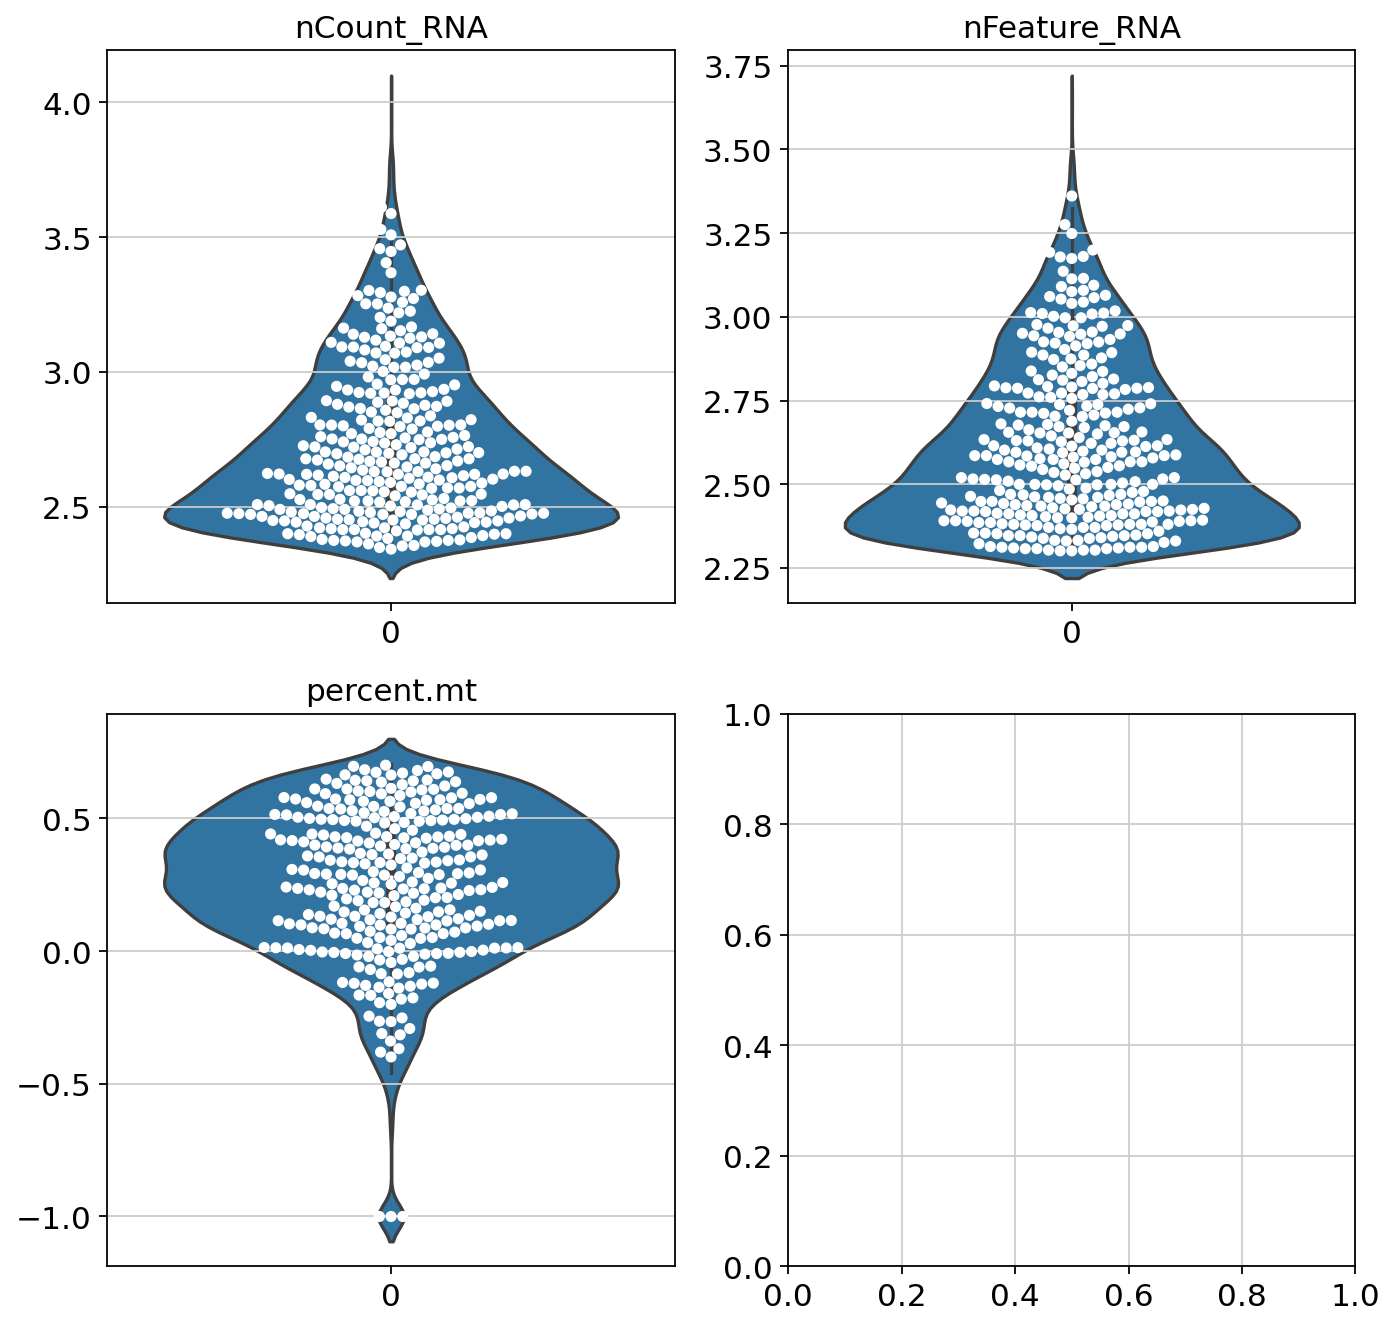

In [18]:
qc_obs = ["nCount_RNA", "nFeature_RNA", "percent.mt"]
nrows_i=2; ncols_i=2; i = 0
fig, axs = plt.subplots(nrows=nrows_i, ncols=ncols_i)
for j in range(nrows_i):
    for k in range(ncols_i):
        if (len(qc_obs)-1) >= i:
            log_data = [np.log10(d+0.1) for d in adata_obs[qc_obs[i]]]
            sns.violinplot(data=log_data, ax=axs[j, k])
            sns.swarmplot(data=random.sample(log_data, 300), color="white", ax=axs[j, k])
            axs[j, k].set_title(qc_obs[i]); i+=1

### Remove doublets [if the info present] <a class="anchor" id="bullet5"></a>

### Make object lightweight <a class="anchor" id="bullet6"></a>
Remove uns, varm, obsm, obsp, layers, and reduce obs columns if duplicated stuff or unlabelled clustering outputs exist.

In [19]:
del adata.uns
del adata.obsm
del adata.varm
del adata.obsp
adata

AnnData object with n_obs × n_vars = 8016 × 24532
    obs: 'institute', 'study_PI', 'sample_ID', 'subject_ID', 'library_ID', 'subject_developmental_state', 'age_years', 'sex', 'smoking_status', 'disease_lung_known', 'disease_condition', 'subject_type', 'sample_type', 'anatomical_region_level1', 'anatomical_region_level3', 'protocol_tissue_dissociation', 'biological_unit', 'library_platform', 'strand_sequence', 'cell_enrichment', 'library_construction_batch', 'sequencing_platform', 'reference_genome', 'reference_genome_ensembl_release', 'sample_collection_year', 'sample_status', 'sample_cultured', 'cell_number_loaded', 'study', 'dataset', 'sample', 'original_celltype_ann', 'disease_status'
    var: 'genes'

### Check if you need to split them into datasets <a class="anchor" id="bullet7"></a>

In [20]:
pd.crosstab(adata.obs.library_platform, adata.obs.dataset)

dataset,Schultze_unpubl
library_platform,
Seq-well,8016


#### Write down everything you did in the "preprocessing" column <a class="anchor" id="bullet8"></a>
Sheet: [Dataset overview](https://docs.google.com/spreadsheets/d/1V_dAIApfDG9Q1lsJGRePzDIosjn--ei-r7PKi9WWBsw/edit#gid=0&range=Q1).

### Subset to HVGs <a class="anchor" id="bullet8"></a>

Pad with 0s if needed.

In [21]:
adata.var

,genes
MT-CO1,MT-CO1
CCDC88A,CCDC88A
CCL3,CCL3
CCL5,CCL5
CSMD1,CSMD1
...,...
AC016705.2,AC016705.2
AC010884.1,AC010884.1
AL031291.1,AL031291.1
AL662884.1,AL662884.1


In [22]:
genes_set = pd.read_csv(genes_set_inp)
genes_set

,Unnamed: 0,gene_symbols
0,ENSG00000000938,FGR
1,ENSG00000000971,CFH
2,ENSG00000002587,HS3ST1
3,ENSG00000002933,TMEM176A
4,ENSG00000003436,TFPI
...,...,...
1995,ENSG00000280721,AC133644.2
1996,ENSG00000281103,TRG-AS1
1997,ENSG00000282122,CH17-262H11.1
1998,ENSG00000282988,RP1-34B20.21


In [23]:
adata_sub = pp.subset_and_pad_adata(genes_set, adata)

not all genes were recovered, filling in 0 counts for 215 missing genes...


In [24]:
adata_sub.var

,genes,gene_symbols,ensembl
FGR,FGR,NaN,ENSG00000000938
CFH,CFH,NaN,ENSG00000000971
HS3ST1,HS3ST1,NaN,ENSG00000002587
TMEM176A,TMEM176A,NaN,ENSG00000002933
TFPI,TFPI,NaN,ENSG00000003436
...,...,...,...
S100A7,NaN,S100A7,ENSG00000143556
AC008268.1,NaN,AC008268.1,ENSG00000235584
STC2,NaN,STC2,ENSG00000113739
RP11-295M3.4,NaN,RP11-295M3.4,ENSG00000277639


In [25]:
vars_keep = ["genes", "gene_symbols", "ensembl"]
for i in list(set(adata_sub.var.columns) - set(vars_keep)):
    del adata_sub.var[i]

In [26]:
adata_sub

AnnData object with n_obs × n_vars = 8016 × 2000
    obs: 'institute', 'study_PI', 'sample_ID', 'subject_ID', 'library_ID', 'subject_developmental_state', 'age_years', 'sex', 'smoking_status', 'disease_lung_known', 'disease_condition', 'subject_type', 'sample_type', 'anatomical_region_level1', 'anatomical_region_level3', 'protocol_tissue_dissociation', 'biological_unit', 'library_platform', 'strand_sequence', 'cell_enrichment', 'library_construction_batch', 'sequencing_platform', 'reference_genome', 'reference_genome_ensembl_release', 'sample_collection_year', 'sample_status', 'sample_cultured', 'cell_number_loaded', 'study', 'dataset', 'sample', 'original_celltype_ann', 'disease_status'
    var: 'genes', 'gene_symbols', 'ensembl'

### Store the data <a class="anchor" id="bullet10"></a>

* full/ all genes
* subsetted/ 2000 genes

In [27]:
adata_sub.write(adata_dir_out+'/full/schultze_unpubl.h5ad')
adata_sub.write(adata_dir_out+'/subsetted/schultze_unpubl.h5ad')

... storing 'institute' as categorical
... storing 'study_PI' as categorical
... storing 'sample_ID' as categorical
... storing 'subject_ID' as categorical
... storing 'library_ID' as categorical
... storing 'subject_developmental_state' as categorical
... storing 'sex' as categorical
... storing 'smoking_status' as categorical
... storing 'disease_lung_known' as categorical
... storing 'disease_condition' as categorical
... storing 'subject_type' as categorical
... storing 'sample_type' as categorical
... storing 'anatomical_region_level1' as categorical
... storing 'anatomical_region_level3' as categorical
... storing 'protocol_tissue_dissociation' as categorical
... storing 'biological_unit' as categorical
... storing 'library_platform' as categorical
... storing 'strand_sequence' as categorical
... storing 'cell_enrichment' as categorical
... storing 'library_construction_batch' as categorical
... storing 'sequencing_platform' as categorical
... storing 'reference_genome' as catego

#### Update the stats for your dataset <a class="anchor" id="bullet11"></a>
Sheet: [Dataset overview](https://docs.google.com/spreadsheets/d/1V_dAIApfDG9Q1lsJGRePzDIosjn--ei-r7PKi9WWBsw/edit#gid=0)